In [23]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filemode='w',
                    filename='air_quality_model.log',
                    force=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA


In [24]:
#creating our first log
logging.info("Importing Air Quality Dataset...")

In [25]:
#Load Dataset
df = pd.read_csv('city_day.csv')
df.sample(frac = 1) 

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
20630,Lucknow,2017-02-23,93.39,NaN,9.07,26.39,NaN,NaN,1.36,7.65,122.82,2.58,6.79,NaN,223.0,Poor
702,Ahmedabad,2016-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN
11357,Delhi,2018-02-02,140.35,282.16,34.69,54.28,71.59,52.36,1.49,12.25,52.12,1.72,5.93,0.79,318.0,Very Poor
10350,Delhi,2015-05-02,72.66,206.10,25.56,62.09,76.22,26.99,9.46,16.16,43.06,3.47,15.83,NaN,312.0,Very Poor
19979,Lucknow,2015-05-14,33.40,NaN,1.58,13.48,4.22,NaN,2.14,9.08,44.04,1.32,1.26,NaN,112.0,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28405,Visakhapatnam,2017-06-02,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN
27496,Thiruvananthapuram,2018-12-07,35.04,53.63,5.18,5.67,7.22,3.83,1.73,4.07,39.66,NaN,NaN,NaN,99.0,Satisfactory
18385,Jorapokhar,2019-03-05,81.29,145.50,9.27,9.28,NaN,6.36,0.00,12.93,15.55,NaN,NaN,NaN,167.0,Moderate
22119,Mumbai,2015-09-22,NaN,NaN,NaN,NaN,27.42,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN


In [26]:
# Checking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [27]:
from collections import OrderedDict
import pandas as pd

stats = []

# Descriptive statistics for numeric features
for col in df.columns:
    if df[col].dtype != 'object':
        numerical_stats = OrderedDict({
            'Feature': col,
            'Minimum': df[col].min(),
            'Maximum': df[col].max(),
            'Mean': df[col].mean(),
            'Mode': df[col].mode()[0] if not df[col].mode().empty else None,
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Standard Deviation': df[col].std(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurt()
        })
        stats.append(numerical_stats)

# Convert stats list to DataFrame
report = pd.DataFrame(stats)

# Outlier Detection using IQR method
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # Lower Whisker
    UW = Q3 + 1.5 * IQR   # Upper Whisker
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

# Add Outlier Comment to the report
report["Outlier Comment"] = outlier_label

# Display final report
report


,Feature,Minimum,Maximum,Mean,Mode,25%,75%,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,PM2.5,0.04,949.99,67.450578,11.00,28.820,80.5900,51.7700,64.661449,3.369960,21.132222,Has Outliers
1,PM10,0.01,1000.00,118.127103,94.00,56.255,149.7450,93.4900,90.605110,2.053189,6.747873,Has Outliers
2,NO,0.02,390.68,17.574730,5.93,5.630,19.9500,14.3200,22.785846,3.883166,25.164347,Has Outliers
3,NO2,0.01,362.21,28.560659,10.58,11.750,37.6200,25.8700,24.474746,2.464560,11.211125,Has Outliers
4,NOx,0.00,467.63,32.309123,0.00,12.820,40.1275,27.3075,31.646011,2.569915,10.836335,Has Outliers
5,NH3,0.01,352.89,23.483476,6.29,8.580,30.0200,21.4400,25.684275,4.083993,27.964608,Has Outliers
6,CO,0.00,175.81,2.248598,0.00,0.510,1.4500,0.9400,6.962884,8.878322,109.488050,Has Outliers
7,SO2,0.01,193.86,14.531977,5.74,5.670,15.2200,9.5500,18.133775,4.083660,22.067101,Has Outliers
8,O3,0.01,257.73,34.491430,16.48,18.860,45.5700,26.7100,21.694928,1.330119,3.429465,Has Outliers
9,Benzene,0.00,455.03,3.280840,0.00,0.120,3.0800,2.9600,15.811136,21.304218,530.171471,Has Outliers


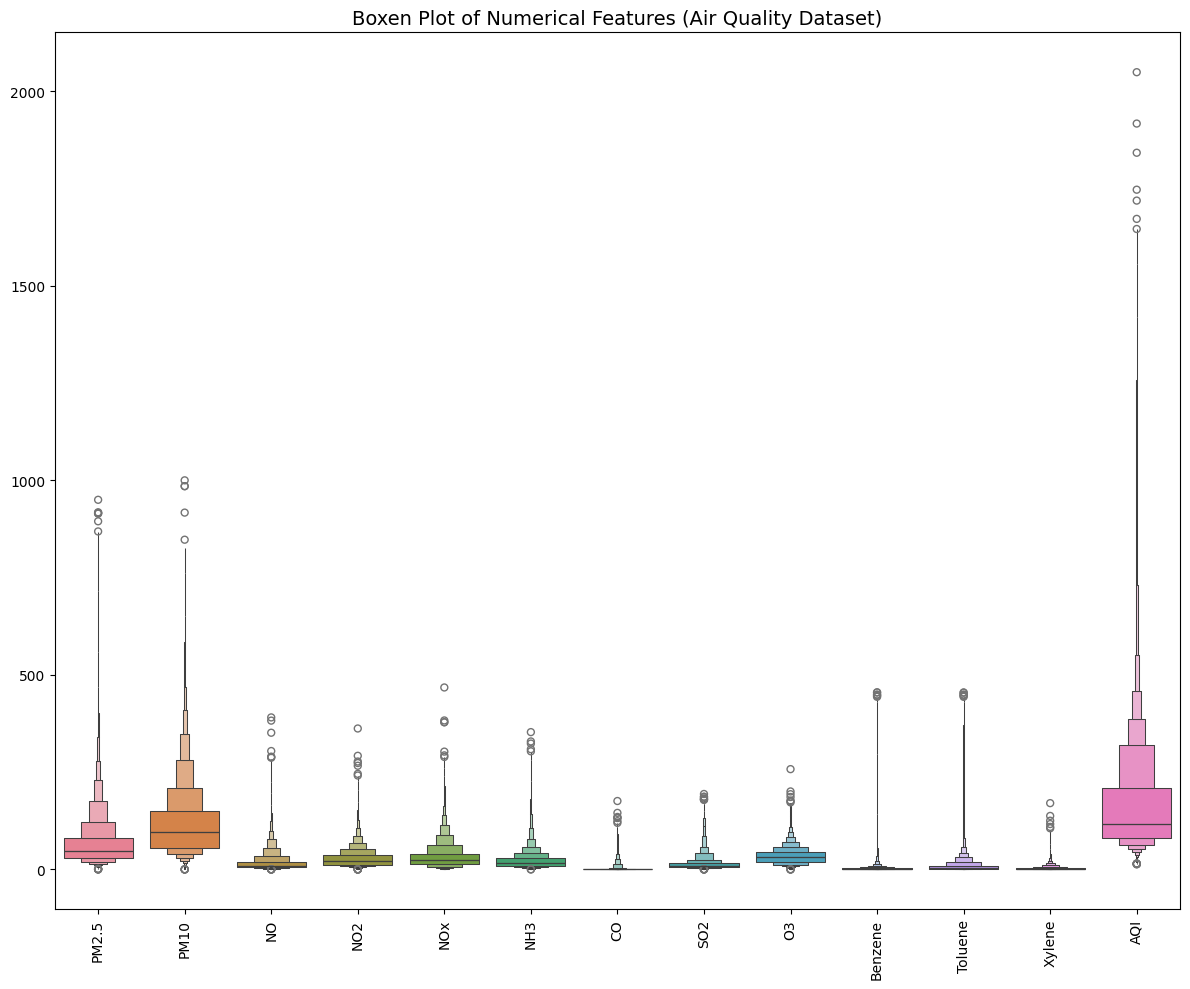

In [28]:
# Select only numeric features
numeric_df = df.select_dtypes(include=['number'])

# Plot Boxenplot
plt.figure(figsize=(12, 10))
sns.boxenplot(data=numeric_df)

plt.xticks(rotation=90)
plt.title("Boxen Plot of Numerical Features (Air Quality Dataset)", fontsize=14)
plt.tight_layout()
plt.show()


In [29]:
# Replace Outliers with Median using IQR method
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        median_value = df[col].median()
        df.loc[outliers, col] = median_value
        print(f"Replaced {outlier_count} outliers in '{col}' with median ({median_value}).")
    else:
        print(f"No outliers found in '{col}'.")


Replaced 1982 outliers in 'PM2.5' with median (48.57).
Replaced 1057 outliers in 'PM10' with median (95.68).
Replaced 2459 outliers in 'NO' with median (9.89).
Replaced 1188 outliers in 'NO2' with median (21.69).
Replaced 1868 outliers in 'NOx' with median (23.52).
Replaced 1015 outliers in 'NH3' with median (15.85).
Replaced 2475 outliers in 'CO' with median (0.89).
Replaced 2578 outliers in 'SO2' with median (9.16).
Replaced 713 outliers in 'O3' with median (30.84).
Replaced 1668 outliers in 'Benzene' with median (1.07).
Replaced 2427 outliers in 'Toluene' with median (2.97).
Replaced 1119 outliers in 'Xylene' with median (0.98).
Replaced 1358 outliers in 'AQI' with median (118.0).


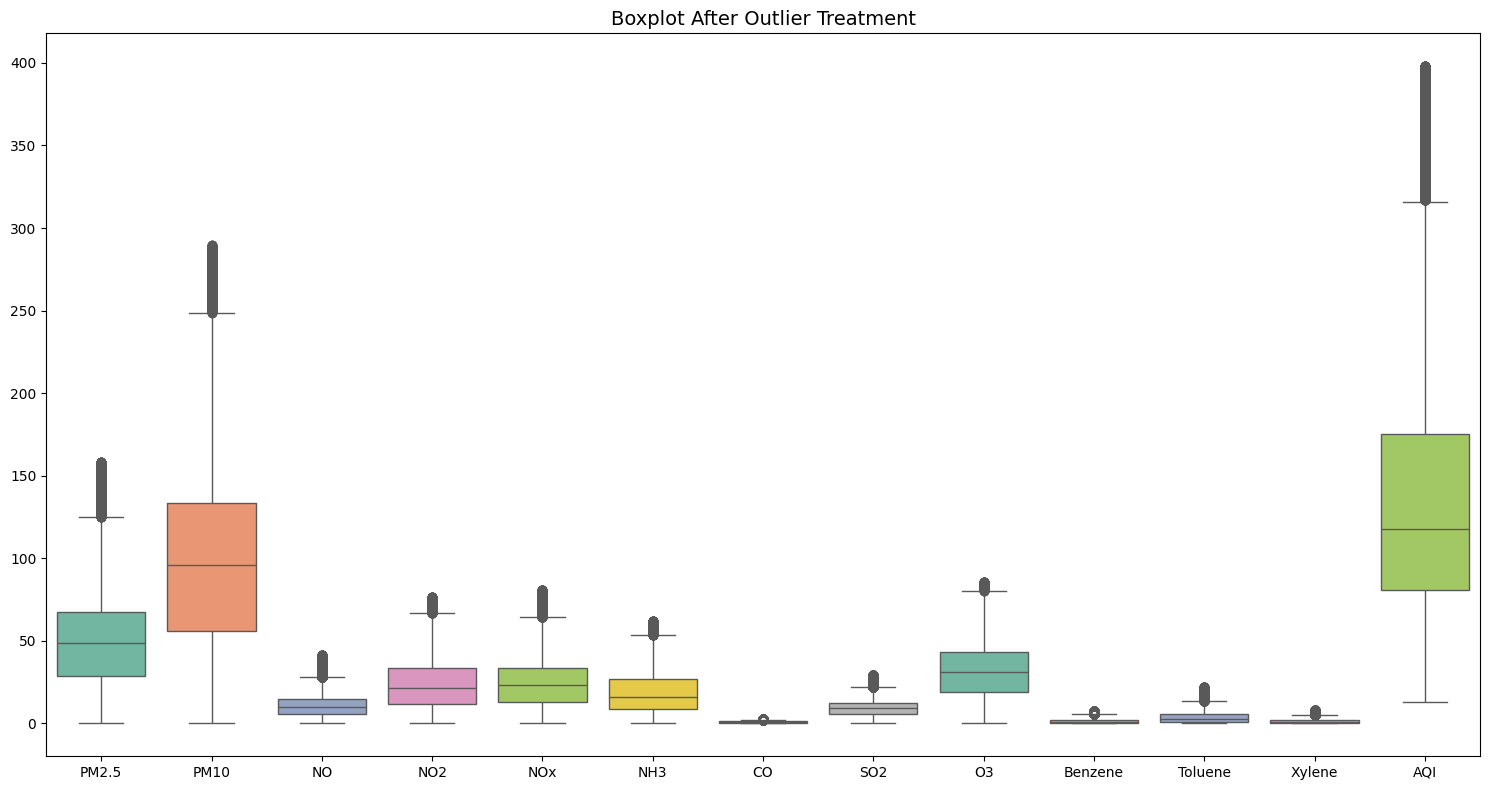

In [30]:
# Set figure size
plt.figure(figsize=(15, 8))

# Select only numerical columns
numeric_df = df.select_dtypes(include='number')

# Create horizontal boxplot
sns.boxplot(data=numeric_df, orient='v', palette='Set2')

# Set title
plt.title('Boxplot After Outlier Treatment', fontsize=14)
plt.tight_layout()
plt.show()


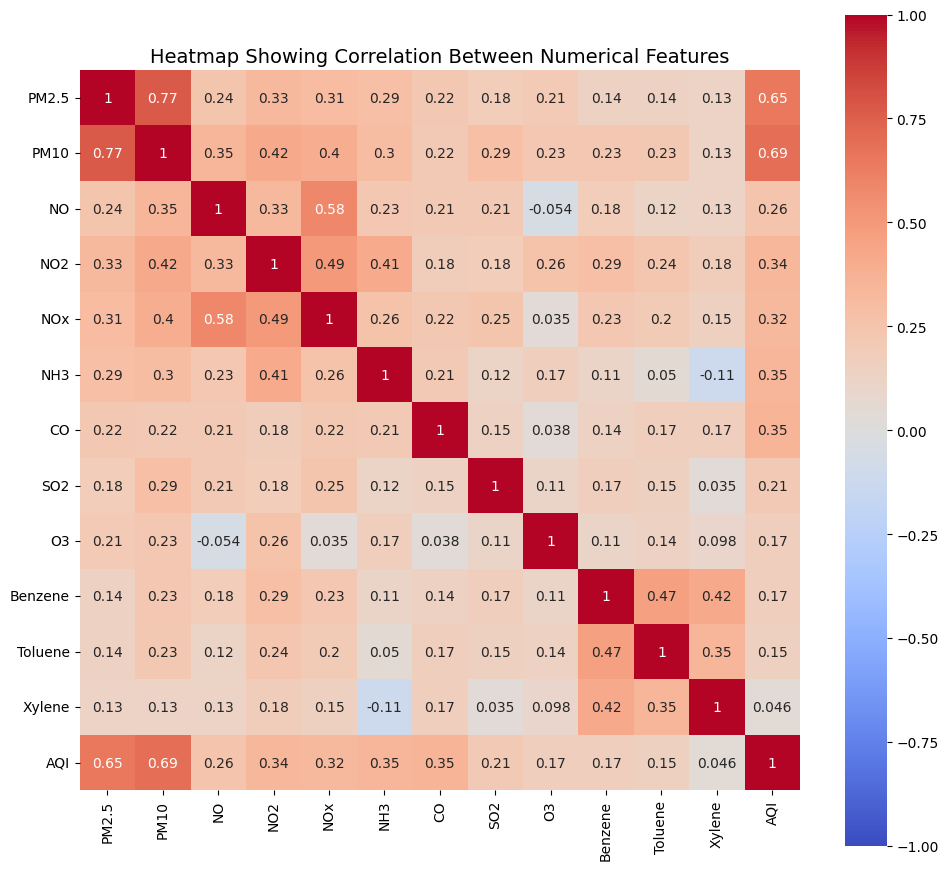

In [31]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 9))  

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True, ax=ax)

plt.title('Heatmap Showing Correlation Between Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()


In [32]:
df.columns

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Drop the target variable
numerical_features = df.select_dtypes(include='number').drop(columns=['AQI'])

# Step 1: Replace inf/-inf with NaN
numerical_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Drop rows with NaN 
numerical_features.dropna(inplace=True)

# Step 3: Calculate VIF
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'], 2)
    vif = vif.sort_values(by='VIF_Values', ascending=False)
    return vif

# Run VIF
vif_report = calculate_vif(numerical_features)
vif_report


,features,VIF_Values
1,PM10,14.51
0,PM2.5,11.01
4,NOx,8.83
3,NO2,7.75
6,CO,6.46
7,SO2,5.40
8,O3,5.25
2,NO,5.20
5,NH3,4.55
9,Benzene,3.57


In [34]:
# Step 0: Import required libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
import time

# Step 1: Separate target and features
target_col = 'AQI'
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 2: Encode categorical variables
for col in X.select_dtypes(include='object').columns:
    unique_vals = X[col].nunique()
    if unique_vals > 20:
        # High-cardinality columns → Label Encoding
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    else:
        # Low-cardinality columns → One-hot encoding
        X = pd.get_dummies(X, columns=[col], drop_first=True)

# Step 3: Handle missing values
X.fillna(X.mean(), inplace=True)

# Step 4: Feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: PCA setup
start = time.time()

# Fit PCA once on full data
pca_full = PCA()
pca_full.fit(X_scaled)

# Get cumulative explained variance
evr = np.cumsum(pca_full.explained_variance_ratio_)

# Select components to retain at least 90% variance
pcs = np.argmax(evr >= 0.90) + 1

print("Explained Variance Ratio (Cumulative):", evr)
print("Number of Components Selected:", pcs)

# Step 6: Apply PCA
pca = PCA(n_components=pcs)
pca_data = pca.fit_transform(X_scaled)

# Step 7: Create new DataFrame with PCA components and target
pca_columns = [f'PC{i+1}' for i in range(pcs)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_df[target_col] = y.reset_index(drop=True)

end = time.time()
print(f"PCA completed in {round(end - start, 2)} seconds")
print("Final PCA DataFrame shape:", pca_df.shape)

# Step 8: View result
pca_df



Explained Variance Ratio (Cumulative): [0.25881022 0.41312905 0.49563871 0.57552633 0.64951391 0.70146232
 0.74979815 0.79017924 0.82377741 0.85474079 0.87812487 0.89972539
 0.91903324 0.93625464 0.95298877 0.96685139 0.97951391 0.99147872
 1.        ]
Number of Components Selected: 13
PCA completed in 0.15 seconds
Final PCA DataFrame shape: (29531, 14)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,AQI
0,0.013599,0.298042,-0.794062,-0.023427,-0.186074,0.120579,-0.001752,-0.055561,0.088110,0.056764,0.677290,0.230387,-0.130453,NaN
1,0.060380,0.337701,-0.573820,0.150211,-0.228036,0.198352,0.152563,0.434520,-0.134629,-0.060570,0.574363,0.167918,-0.126642,NaN
2,0.162249,0.492792,-0.220632,0.397710,-0.298787,0.306447,0.385210,0.562959,-0.339648,-0.358775,0.739360,0.261344,-0.241379,NaN
3,0.088481,0.371232,-0.496654,0.170418,-0.255499,0.289525,0.149913,0.483037,-0.240746,0.068263,0.403981,0.268919,-0.235775,NaN
4,0.157699,0.486356,-0.220855,0.417052,-0.310872,0.411273,0.422711,0.624592,-0.386745,-0.418964,0.120477,0.059131,-0.345644,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,-0.105028,0.041616,0.337153,-0.432792,0.100770,-0.448892,0.249964,0.249426,0.006717,-0.224215,-0.132312,0.283481,-0.116578,41.0
29527,-0.817954,-0.321373,0.440327,-0.251063,0.161446,-0.119340,-0.033253,-0.053769,0.231468,0.025478,0.075356,0.065880,0.108983,70.0
29528,-0.839729,-0.343647,0.374664,-0.294629,0.166610,-0.122314,-0.057085,-0.153308,0.283518,0.036585,-0.071795,0.024362,0.088774,68.0
29529,-0.851525,-0.354406,0.380170,-0.299383,0.157728,-0.139854,-0.037233,-0.172001,0.251051,0.036792,-0.036762,0.063907,0.058440,54.0


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Drop rows with missing AQI 
pca_df = pca_df.dropna(subset=['AQI'])

# Step 2: Define features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate
y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")




Linear Regression Evaluation
RMSE: 28.62
R² Score: 0.89


In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Drop missing target values
pca_df = pca_df.dropna(subset=['AQI'])

# Step 2: Define features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Take a small sample to force underfitting
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Step 5: Underfit Decision Tree Model
dt_underfit = DecisionTreeRegressor(
    max_depth=2,      
    min_samples_leaf=20, 
    random_state=42
)

# Step 6: Fit the model
dt_underfit.fit(X_train_small, y_train_small)

# Step 7: Predict and evaluate
y_pred = dt_underfit.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Decision Tree Regressor Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


 Decision Tree Regressor Evaluation
RMSE: 33.83
R² Score: 0.84


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score



# Step 1: Drop rows with missing AQI 
pca_df = pca_df.dropna(subset=['AQI'])

# Step 2: Split features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Use only part of training data for underfitting
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Step 5: Build underfit Random Forest model
rf_underfit = RandomForestRegressor(
    n_estimators=10,      
    max_depth=3,          
    max_features=3,       
    random_state=42
)

# Step 6: Fit model on smaller data
rf_underfit.fit(X_train_small, y_train_small)

# Step 7: Predict & evaluate
y_pred = rf_underfit.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(" Random Forest Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


 Random Forest Evaluation
RMSE: 31.24
R² Score: 0.87


In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score



# Step 1: Drop rows with missing AQI 
pca_df = pca_df.dropna(subset=['AQI'])

# Step 2: Split features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Use partial data to promote underfitting
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Step 5: Create an underfit XGBoost Regressor
xgb_underfit = XGBRegressor(
    n_estimators=10,      
    max_depth=2,          
    learning_rate=0.5,    
    subsample=0.5,        
    colsample_bytree=0.5, 
    random_state=42,
    verbosity=0
)

# Step 6: Train the model
xgb_underfit.fit(X_train_small, y_train_small)

# Step 7: Predict & evaluate
y_pred = xgb_underfit.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Regressor Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")




XGBoost Regressor Evaluation
RMSE: 24.40
R² Score: 0.92


In [39]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Step 1: Drop rows where AQI  is missing
pca_df = pca_df.dropna(subset=['AQI'])

# Step 2: Split features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

#  Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Step 4: Use smaller subset to promote underfitting
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

#  Step 5: Create an underfit AdaBoost Regressor using 'estimator'
ada_underfit = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=2),
    n_estimators=10,
    learning_rate=0.5,
    random_state=42
)

#  Step 6: Train the model
ada_underfit.fit(X_train_small, y_train_small)

#  Step 7: Predictions and evaluation
y_pred = ada_underfit.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("AdaBoost Regressor Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



AdaBoost Regressor Evaluation
RMSE: 31.83
R² Score: 0.86


In [40]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#  Step 1: Drop rows where AQI  is missing
pca_df = pca_df.dropna(subset=['AQI'])

#  Step 2: Split features and target
X = pca_df.drop(columns='AQI')
y = pca_df['AQI']

#  Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Step 4: Use smaller subset to promote underfitting
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

#  Step 5: Initialize a weak Gradient Boosting model
gb_underfit = GradientBoostingRegressor(
    n_estimators=10,     
    learning_rate=0.5,   
    max_depth=2,         
    subsample=0.5,       
    random_state=42
)

#  Step 6: Train the model
gb_underfit.fit(X_train_small, y_train_small)

#  Step 7: Prediction and Evaluation
y_pred = gb_underfit.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Regressor  Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Gradient Boosting Regressor  Evaluation
RMSE: 23.50
R² Score: 0.92


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

#  1. Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#  2. Random Forest 
best_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
best_rf.fit(X_train, y_train)

#  3. XGBoost
best_xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
best_xgb.fit(X_train, y_train)

#  4. AdaBoost
from sklearn.tree import DecisionTreeRegressor
best_ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.1, random_state=42)
best_ada.fit(X_train, y_train)



from sklearn.metrics import r2_score, mean_squared_error

models = {
    "Linear Regression": model_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "AdaBoost": best_ada,
   
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} → R²: {r2:.3f}, RMSE: {rmse:.2f}")



Linear Regression → R²: 0.887, RMSE: 28.62
Random Forest → R²: 0.948, RMSE: 19.41
XGBoost → R²: 0.946, RMSE: 19.74
AdaBoost → R²: 0.907, RMSE: 25.94


In [42]:
import numpy as np
import joblib

# Load trained model
model = joblib.load("aqi_random_forest_model.pkl")  

# Define PCA input values (PC1 to PC13)
pca_input = [1.5, -0.9, 0.7, -1.3, 2.2, 0.4, -0.6, 1.0, -0.3, 1.6, -1.0, 0.6, 0.8] 

# Convert to 2D array
input_array = np.array(pca_input).reshape(1, -1)

# Predict AQI
predicted_aqi = model.predict(input_array)[0]
print("Predicted AQI:", round(predicted_aqi, 2))

# AQI Category Interpretation
def get_aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

category = get_aqi_category(predicted_aqi)



Predicted AQI: 251.57


In [43]:
import joblib

# Save the best model (Random Forest)
joblib.dump(best_rf, 'aqi_random_forest_model.pkl')




['aqi_random_forest_model.pkl']

In [44]:
import gradio as gr
import joblib
import numpy as np

# Load model and scaler
model = joblib.load("aqi_random_forest_model.pkl")
scaler = joblib.load("scaler.pkl")  # Comment if not used during training

# ✅ Replace with actual mean values if available
default_values = {
    'PC4': -1.23,
    'PC5': 0.56,
    'PC6': -0.89,
    'PC7': 1.02,
    'PC8': 0.13,
    'PC9': -0.44,
    'PC10': 0.77,
    'PC11': 0.08,
    'PC12': -0.11,
    'PC13': 0.33
}

# AQI Category Labeling
def get_aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

# Prediction function
def predict_aqi(pc1, pc2, pc3):
    # Merge user input with defaults
    full_input = [pc1, pc2, pc3] + [default_values[f'PC{i}'] for i in range(4, 14)]
    features = np.array(full_input).reshape(1, -1)

    # Scale if scaler used
    scaled = scaler.transform(features)  # comment out if not used
    prediction = model.predict(scaled)[0]
    category = get_aqi_category(prediction)

    return f"{prediction:.2f}", category

# Gradio app UI
iface = gr.Interface(
    fn=predict_aqi,
    inputs=[
        gr.Number(label="PC1", value=0.0),
        gr.Number(label="PC2", value=0.0),
        gr.Number(label="PC3", value=0.0)
    ],
    outputs=[
        gr.Textbox(label="Predicted AQI"),
        gr.Textbox(label="AQI Category")
    ],
    title="🌍 Simplified AQI Predictor",
    description="Enter PCA components PC1–PC3 to predict AQI using a trained Random Forest model."
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
